# Image Classification for Clothing Attributes - Print Classifier

## 1. Data Preparation

In [27]:
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import os
import shutil

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.data.experimental import AUTOTUNE
from tensorflow import keras

In [14]:
prints = ['animal', 'camo', 'floral', 'other', 'paisley', 'plaid', 'polka', 'solid', 'stripe', 'tiedie']
for i in prints:
    #os.mkdir(f'print/{i}')
    print(i, len(os.listdir(f'print/{i}')))

animal 1124
camo 1054
floral 1216
other 1178
paisley 1122
plaid 1024
polka 1193
solid 1094
stripe 1016
tiedie 1167


In [16]:
def Split(directory, validation = 0.3, inception = False):  
    '''Split the original dataset into the training and validation set'''
    if inception == False:
        IMG_DIM = 224      # for ResNet v2
    else:
        IMG_DIM = 299       # for Inception ResNet v2
    
    BATCH_SIZE = 64

    train_ds = image_dataset_from_directory(directory,
                                                image_size=(IMG_DIM,IMG_DIM),
                                                label_mode="categorical",
                                                batch_size=BATCH_SIZE,
                                                validation_split = validation,
                                                subset="training",
                                                seed=117,
                                                shuffle=True)

    val_ds = image_dataset_from_directory(directory,
                                                image_size=(IMG_DIM,IMG_DIM),
                                                label_mode="categorical",
                                                batch_size=BATCH_SIZE,
                                                validation_split = validation,
                                                subset="validation",
                                                seed=117,
                                                shuffle=True)
    
    

    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds

In [15]:
def dataAug(train_ds, num=5):
    '''To perform data augmentation on the training set'''
    aug1 = layers.experimental.preprocessing.RandomFlip("horizontal")
    ds_1 = train_ds.map(lambda x, y: (aug1(x), y), num_parallel_calls=AUTOTUNE)
    aug2 = layers.experimental.preprocessing.RandomRotation(0.2)
    ds_2 = train_ds.map(lambda x, y: (aug2(x), y), num_parallel_calls=AUTOTUNE)
    aug3 = layers.RandomContrast(0.4)
    ds_3 = train_ds.map(lambda x, y: (aug3(x), y), num_parallel_calls=AUTOTUNE)
    aug4 = layers.RandomBrightness(0.4)
    ds_4 = train_ds.map(lambda x, y: (aug4(x), y), num_parallel_calls=AUTOTUNE)
    aug5 = layers.RandomTranslation(0.3, 0.3)
    ds_5 = train_ds.map(lambda x, y: (aug5(x), y), num_parallel_calls=AUTOTUNE)
    for i in range(num):
        train_ds = train_ds.concatenate(locals()[f'ds_{i+1}'])
    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    return train_ds

In [19]:
# Split the dataset
print_train, print_val = Split('print', 0.4)

Found 11161 files belonging to 10 classes.
Using 6697 files for training.
Found 11161 files belonging to 10 classes.
Using 4464 files for validation.


In [20]:
# Check the number of batches for each set
print(len(print_train))
print(len(print_val))

105
70


In [21]:
# Apply data augmentation on the training set and check for the new number of batches
print_train = dataAug(print_train, 5)
#print_val = dataAug(print_val, 3)
print(len(print_train))
#print(len(print_val))

630


## 2. Complie and Train the model

In [17]:
def RUN(train_ds, val_ds, category, inception = False, trainable = False, epoch = 60, earlystop = 10):
    '''Build and train the model'''
    n_classes = train_ds.element_spec[1].shape[-1]

    if inception == False:
        IMG_DIM = 224      # for ResNet v2
        basemodel_path = "https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5"
    else:
        IMG_DIM = 299       # for Inception ResNet v2
        basemodel_path = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5"
   
    model = Sequential([
        #preprocessing.Rescaling(1/.255, input_shape = (IMG_DIM, IMG_DIM,3)),
        #hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5",
        #hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5",
        hub.KerasLayer(basemodel_path,
        trainable = trainable,
        arguments = dict(batch_norm_momentum = 0.997)),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(n_classes, activation='softmax')
        ])
    model.build([None, IMG_DIM, IMG_DIM, 3])
    model.summary()

    ## Complie the model
    model.compile(optimizer='adam',
              loss="categorical_crossentropy",     # SparseCategoricalCrossentropy used for interger Yi; CategoricalCrossentropy used for one-hot Yi
              metrics=['accuracy'])
    
    ## Fit the model
    epochs = epoch

    checkpoint = ModelCheckpoint(f"weights_{category}.hdf5", monitor='val_accuracy', mode="max", verbose = 1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=earlystop)
    callback_list = [checkpoint, early_stopping]

    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callback_list
    )

    return history

In [ ]:
def Continue(train_ds, val_ds, category, model_path, epoch=60, earlystop=10):
    '''Continue model training based on the model that has been already trained'''
    model = keras.models.load_model(model_path, custom_objects={'KerasLayer':hub.KerasLayer})
    model.summary()

    ## Complie the model
    model.compile(optimizer='adam',
              loss="categorical_crossentropy",     # SparseCategoricalCrossentropy used for interger Yi; CategoricalCrossentropy used for one-hot Yi
              metrics=['accuracy'])
    
    ## Fit the model
    epochs = epoch

    checkpoint = ModelCheckpoint(f"weights_{category}.hdf5", monitor='val_accuracy', mode="max", verbose = 1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=earlystop)
    callback_list = [checkpoint, early_stopping]

    history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callback_list
    )

    return history

In [18]:
def Vis(category, *history):
    '''Visualize the training process'''
    acc=[]
    val_acc=[]
    loss=[]
    val_loss=[]
    
    for hist in history:
        acc.append(hist.history['accuracy'])
        val_acc.append(hist.history['val_accuracy'])
        loss.append(hist.history['loss'])
        val_loss.append(hist.history['val_loss'])

    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{category}: Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{category}: Training and Validation Loss')
    plt.savefig(f'{category}.png')
    plt.show()


In [ ]:
# Train the model
print_hist = Continue(print_train, print_val, 'Print_withAug_ResNetV2', "weights_Print_withAug_ResNetV2.hdf5", 50, 15)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              25615849  
                                                                 
 dropout (Dropout)           (None, 1001)              0         
                                                                 
 flatten (Flatten)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 10)                10020     
                                                                 
Total params: 25,625,869
Trainable params: 25,580,429
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/50
  4/630 [..............................] - ETA: 1:04:44 - loss: 0.7331 - accuracy: 0.9336

2023-05-04 07:45:44.130386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 1:02:52 - loss: 0.6750 - accuracy: 0.9477

2023-05-04 07:48:21.396164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 54:19 - loss: 0.7066 - accuracy: 0.9397

2023-05-04 07:56:48.712387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 51:45 - loss: 0.6964 - accuracy: 0.9424

2023-05-04 07:59:26.238947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 43:19 - loss: 0.6908 - accuracy: 0.9454

2023-05-04 08:07:46.112144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 40:43 - loss: 0.6832 - accuracy: 0.9483

2023-05-04 08:10:23.130154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 32:22 - loss: 0.6730 - accuracy: 0.9516

2023-05-04 08:18:44.304861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 29:45 - loss: 0.6704 - accuracy: 0.9524

2023-05-04 08:21:21.243017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 21:23 - loss: 0.6687 - accuracy: 0.9540

2023-05-04 08:29:40.058473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 18:47 - loss: 0.6678 - accuracy: 0.9545

2023-05-04 08:32:17.149415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 10:25 - loss: 0.6710 - accuracy: 0.9550

2023-05-04 08:40:35.185793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:49 - loss: 0.6713 - accuracy: 0.9551

2023-05-04 08:43:11.244672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.6713 - accuracy: 0.9559
Epoch 1: val_accuracy improved from -inf to 0.54615, saving model to weights_Print_withAug_ResNetV2.hdf5
630/630 [==============================] - 4035s 6s/step - loss: 0.6713 - accuracy: 0.9559 - val_loss: 2.5374 - val_accuracy: 0.5461
Epoch 2/50
  4/630 [..............................] - ETA: 1:04:32 - loss: 0.6222 - accuracy: 0.9727

2023-05-04 08:52:50.234504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 1:02:20 - loss: 0.6504 - accuracy: 0.9688

2023-05-04 08:55:26.023562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 53:26 - loss: 0.6700 - accuracy: 0.9651

2023-05-04 09:03:43.783842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 50:47 - loss: 0.6704 - accuracy: 0.9646

2023-05-04 09:06:16.645068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 41:51 - loss: 0.6706 - accuracy: 0.9640

2023-05-04 09:14:06.837432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 39:12 - loss: 0.6666 - accuracy: 0.9652

2023-05-04 09:16:33.595889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 30:59 - loss: 0.6660 - accuracy: 0.9653

2023-05-04 09:24:25.189290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 28:27 - loss: 0.6640 - accuracy: 0.9662

2023-05-04 09:26:52.197910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 20:39 - loss: 0.6630 - accuracy: 0.9659

2023-05-04 09:35:15.706125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 18:06 - loss: 0.6639 - accuracy: 0.9659

2023-05-04 09:37:43.260348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 10:00 - loss: 0.6668 - accuracy: 0.9658

2023-05-04 09:45:29.781250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:30 - loss: 0.6672 - accuracy: 0.9659

2023-05-04 09:47:59.110550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.6647 - accuracy: 0.9670
Epoch 2: val_accuracy did not improve from 0.54615
630/630 [==============================] - 3856s 6s/step - loss: 0.6647 - accuracy: 0.9670 - val_loss: 4.5382 - val_accuracy: 0.4738
Epoch 3/50
  4/630 [..............................] - ETA: 1:02:12 - loss: 0.6481 - accuracy: 0.9688

2023-05-04 09:57:05.460443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 59:21 - loss: 0.6404 - accuracy: 0.9720

2023-05-04 09:59:33.645448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 51:19 - loss: 0.6477 - accuracy: 0.9719

2023-05-04 10:07:33.169235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 48:58 - loss: 0.6483 - accuracy: 0.9723

2023-05-04 10:10:03.034756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 41:07 - loss: 0.6682 - accuracy: 0.9684

2023-05-04 10:17:59.946756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 38:38 - loss: 0.6709 - accuracy: 0.9687

2023-05-04 10:20:28.673828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 30:39 - loss: 0.6747 - accuracy: 0.9686

2023-05-04 10:28:20.498165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 28:10 - loss: 0.6733 - accuracy: 0.9692

2023-05-04 10:30:48.465317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 20:14 - loss: 0.6684 - accuracy: 0.9705

2023-05-04 10:38:38.757252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 17:45 - loss: 0.6643 - accuracy: 0.9716

2023-05-04 10:41:06.546868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 9:52 - loss: 0.6581 - accuracy: 0.9728

2023-05-04 10:49:03.285503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:25 - loss: 0.6579 - accuracy: 0.9727

2023-05-04 10:51:36.951008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.9725
Epoch 3: val_accuracy improved from 0.54615 to 0.64023, saving model to weights_Print_withAug_ResNetV2.hdf5
630/630 [==============================] - 3823s 6s/step - loss: 0.6564 - accuracy: 0.9725 - val_loss: 2.5061 - val_accuracy: 0.6402
Epoch 4/50
  4/630 [..............................] - ETA: 1:00:49 - loss: 0.6361 - accuracy: 0.9688

2023-05-04 11:00:48.316062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 59:14 - loss: 0.6569 - accuracy: 0.9671

2023-05-04 11:03:16.508302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 51:35 - loss: 0.6953 - accuracy: 0.9601

2023-05-04 11:11:19.721963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 49:15 - loss: 0.6880 - accuracy: 0.9634

2023-05-04 11:13:51.094451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 41:11 - loss: 0.6811 - accuracy: 0.9665

2023-05-04 11:21:45.470811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 38:43 - loss: 0.6822 - accuracy: 0.9664

2023-05-04 11:24:14.566477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 30:43 - loss: 0.6784 - accuracy: 0.9677

2023-05-04 11:32:07.876000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 28:15 - loss: 0.6750 - accuracy: 0.9687

2023-05-04 11:34:37.036569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 20:17 - loss: 0.6644 - accuracy: 0.9712

2023-05-04 11:42:28.623773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 17:48 - loss: 0.6607 - accuracy: 0.9718

2023-05-04 11:44:57.401157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 9:53 - loss: 0.6496 - accuracy: 0.9739

2023-05-04 11:52:50.125848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:24 - loss: 0.6466 - accuracy: 0.9744

2023-05-04 11:55:17.558147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.6448 - accuracy: 0.9740
Epoch 4: val_accuracy did not improve from 0.64023
630/630 [==============================] - 3818s 6s/step - loss: 0.6448 - accuracy: 0.9740 - val_loss: 3.4744 - val_accuracy: 0.4966
Epoch 5/50
  4/630 [..............................] - ETA: 1:02:59 - loss: 0.6490 - accuracy: 0.9570

2023-05-04 12:04:27.707029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 59:28 - loss: 0.6533 - accuracy: 0.9661

2023-05-04 12:06:55.919266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 51:36 - loss: 0.6686 - accuracy: 0.9661

2023-05-04 12:14:58.595142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 49:08 - loss: 0.6665 - accuracy: 0.9675

2023-05-04 12:17:27.962815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 41:05 - loss: 0.6595 - accuracy: 0.9708

2023-05-04 12:25:21.092673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 38:36 - loss: 0.6615 - accuracy: 0.9695

2023-05-04 12:27:49.416377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 30:39 - loss: 0.6643 - accuracy: 0.9691

2023-05-04 12:35:42.777727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 28:10 - loss: 0.6627 - accuracy: 0.9699

2023-05-04 12:38:10.478567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 20:14 - loss: 0.6544 - accuracy: 0.9724

2023-05-04 12:46:01.147885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 17:47 - loss: 0.6526 - accuracy: 0.9727

2023-05-04 12:48:31.575733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


464/630 [=====================>........] - ETA: 16:24 - loss: 0.6529 - accuracy: 0.9726

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



320/630 [==============>...............] - ETA: 29:32 - loss: 0.5656 - accuracy: 0.9861

2023-05-04 17:47:40.868368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 27:11 - loss: 0.5653 - accuracy: 0.9860

2023-05-04 17:50:06.683746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


420/630 [===================>..........] - ETA: 20:00 - loss: 0.5625 - accuracy: 0.9858

2023-05-04 17:58:01.029083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 123 of 512
2023-05-04 17:58:01.029148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 124 of 512
2023-05-04 17:58:01.029162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 125 of 512
2023-05-04 17:58:01.029177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 126 of 512
2023-05-04 17:58:01.084216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 127 of 512
2023-05-04 17:58:02.669620: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


423/630 [===================>..........] - ETA: 20:08 - loss: 0.5623 - accuracy: 0.9859

2023-05-04 17:58:20.247625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


448/630 [====================>.........] - ETA: 17:40 - loss: 0.5600 - accuracy: 0.9862

2023-05-04 18:00:41.899987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


529/630 [========================>.....] - ETA: 9:46 - loss: 0.5560 - accuracy: 0.9862

2023-05-04 18:08:20.786378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


554/630 [=========================>....] - ETA: 7:20 - loss: 0.5547 - accuracy: 0.9862

2023-05-04 18:10:43.295500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.5552 - accuracy: 0.9852
Epoch 10: val_accuracy did not improve from 0.65950
630/630 [==============================] - 3723s 6s/step - loss: 0.5552 - accuracy: 0.9852 - val_loss: 5.1306 - val_accuracy: 0.3931
Epoch 11/50
  4/630 [..............................] - ETA: 59:38 - loss: 0.5691 - accuracy: 0.9727

2023-05-04 18:19:37.327304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 56:49 - loss: 0.5824 - accuracy: 0.9731

2023-05-04 18:21:59.084495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 49:08 - loss: 0.5829 - accuracy: 0.9765

2023-05-04 18:29:38.242800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 46:50 - loss: 0.5813 - accuracy: 0.9766

2023-05-04 18:32:00.949606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 39:16 - loss: 0.5830 - accuracy: 0.9773

2023-05-04 18:39:35.438424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 36:55 - loss: 0.5852 - accuracy: 0.9772

2023-05-04 18:41:57.710930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


319/630 [==============>...............] - ETA: 29:26 - loss: 0.5900 - accuracy: 0.9769

2023-05-04 18:49:26.114871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


344/630 [===============>..............] - ETA: 27:04 - loss: 0.5881 - accuracy: 0.9777

2023-05-04 18:51:48.284960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 19:24 - loss: 0.5854 - accuracy: 0.9782

2023-05-04 18:59:28.479691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 17:02 - loss: 0.5851 - accuracy: 0.9784

2023-05-04 19:01:51.649664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 9:28 - loss: 0.5835 - accuracy: 0.9782

2023-05-04 19:09:27.889504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:06 - loss: 0.5818 - accuracy: 0.9786

2023-05-04 19:11:52.581805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.5814 - accuracy: 0.9783
Epoch 11: val_accuracy did not improve from 0.65950
630/630 [==============================] - 3673s 6s/step - loss: 0.5814 - accuracy: 0.9783 - val_loss: 9.8575 - val_accuracy: 0.3544
Epoch 12/50
  4/630 [..............................] - ETA: 59:32 - loss: 0.5631 - accuracy: 0.9805

2023-05-04 19:20:50.014823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 57:32 - loss: 0.5867 - accuracy: 0.9736

2023-05-04 19:23:13.794830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 50:01 - loss: 0.5995 - accuracy: 0.9752

2023-05-04 19:31:01.991058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 47:42 - loss: 0.5987 - accuracy: 0.9749

2023-05-04 19:33:27.854110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 40:01 - loss: 0.5929 - accuracy: 0.9766

2023-05-04 19:41:11.156898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 37:35 - loss: 0.5905 - accuracy: 0.9769

2023-05-04 19:43:35.115999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 29:47 - loss: 0.5780 - accuracy: 0.9793

2023-05-04 19:51:12.161191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 27:22 - loss: 0.5733 - accuracy: 0.9802

2023-05-04 19:53:35.246137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 19:38 - loss: 0.5599 - accuracy: 0.9827

2023-05-04 20:01:11.273061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 17:15 - loss: 0.5556 - accuracy: 0.9833

2023-05-04 20:03:34.905921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 9:34 - loss: 0.5441 - accuracy: 0.9848

2023-05-04 20:11:12.055699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:10 - loss: 0.5405 - accuracy: 0.9851

2023-05-04 20:13:34.978084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.5346 - accuracy: 0.9853
Epoch 12: val_accuracy did not improve from 0.65950
630/630 [==============================] - 3693s 6s/step - loss: 0.5346 - accuracy: 0.9853 - val_loss: 4.6009 - val_accuracy: 0.4321
Epoch 13/50
  4/630 [..............................] - ETA: 59:13 - loss: 0.4906 - accuracy: 0.9883

2023-05-04 20:22:23.012047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 56:59 - loss: 0.5209 - accuracy: 0.9822

2023-05-04 20:24:45.438193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 49:11 - loss: 0.5299 - accuracy: 0.9806

2023-05-04 20:32:24.629631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 46:52 - loss: 0.5324 - accuracy: 0.9800

2023-05-04 20:34:47.602169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 39:22 - loss: 0.5503 - accuracy: 0.9764

2023-05-04 20:42:24.204410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 37:01 - loss: 0.5528 - accuracy: 0.9760

2023-05-04 20:44:47.204333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 29:23 - loss: 0.5604 - accuracy: 0.9751

2023-05-04 20:52:20.497092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 27:01 - loss: 0.5607 - accuracy: 0.9753

2023-05-04 20:54:43.027853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 19:26 - loss: 0.5586 - accuracy: 0.9766

2023-05-04 21:02:18.189175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 17:04 - loss: 0.5565 - accuracy: 0.9773

2023-05-04 21:04:41.862767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 9:29 - loss: 0.5509 - accuracy: 0.9786

2023-05-04 21:12:18.023709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:07 - loss: 0.5483 - accuracy: 0.9793

2023-05-04 21:14:40.250364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.5426 - accuracy: 0.9805
Epoch 13: val_accuracy did not improve from 0.65950
630/630 [==============================] - 3672s 6s/step - loss: 0.5426 - accuracy: 0.9805 - val_loss: 2.0420 - val_accuracy: 0.6449
Epoch 14/50
  4/630 [..............................] - ETA: 59:41 - loss: 0.4975 - accuracy: 0.9883

2023-05-04 21:23:34.864615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 57:17 - loss: 0.5154 - accuracy: 0.9865

2023-05-04 21:25:58.006932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 49:31 - loss: 0.5193 - accuracy: 0.9826

2023-05-04 21:33:40.518491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 47:12 - loss: 0.5301 - accuracy: 0.9802

2023-05-04 21:36:04.623898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 39:33 - loss: 0.5596 - accuracy: 0.9743

2023-05-04 21:43:41.857233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 37:12 - loss: 0.5672 - accuracy: 0.9731

2023-05-04 21:46:06.148312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 29:36 - loss: 0.5848 - accuracy: 0.9705

2023-05-04 21:53:46.051534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 27:13 - loss: 0.5867 - accuracy: 0.9707

2023-05-04 21:56:09.271016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 19:32 - loss: 0.5818 - accuracy: 0.9738

2023-05-04 22:03:43.172429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 17:09 - loss: 0.5789 - accuracy: 0.9747

2023-05-04 22:06:06.498598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 9:31 - loss: 0.5716 - accuracy: 0.9767

2023-05-04 22:13:40.680558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:08 - loss: 0.5684 - accuracy: 0.9775

2023-05-04 22:16:02.297317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.5606 - accuracy: 0.9789
Epoch 14: val_accuracy did not improve from 0.65950
630/630 [==============================] - 3676s 6s/step - loss: 0.5606 - accuracy: 0.9789 - val_loss: 3.2299 - val_accuracy: 0.5811
Epoch 15/50
  4/630 [..............................] - ETA: 59:18 - loss: 0.4915 - accuracy: 0.9922

2023-05-04 22:24:50.147742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 57:18 - loss: 0.4923 - accuracy: 0.9908

2023-05-04 22:27:13.391682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 49:23 - loss: 0.4901 - accuracy: 0.9893

2023-05-04 22:34:54.231716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 46:59 - loss: 0.4868 - accuracy: 0.9900

2023-05-04 22:37:16.444210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 39:19 - loss: 0.5001 - accuracy: 0.9859

2023-05-04 22:44:49.794208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 36:58 - loss: 0.5053 - accuracy: 0.9853

2023-05-04 22:47:12.536210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 29:21 - loss: 0.5159 - accuracy: 0.9830

2023-05-04 22:54:46.238992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 27:02 - loss: 0.5164 - accuracy: 0.9833

2023-05-04 22:57:11.402519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 19:32 - loss: 0.5266 - accuracy: 0.9813

2023-05-04 23:04:58.792018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 17:11 - loss: 0.5292 - accuracy: 0.9809

2023-05-04 23:07:25.742779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 9:33 - loss: 0.5331 - accuracy: 0.9805

2023-05-04 23:15:09.551737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:10 - loss: 0.5332 - accuracy: 0.9807

2023-05-04 23:17:34.770135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.5323 - accuracy: 0.9809
Epoch 15: val_accuracy did not improve from 0.65950
630/630 [==============================] - 3699s 6s/step - loss: 0.5323 - accuracy: 0.9809 - val_loss: 3.6594 - val_accuracy: 0.5233
Epoch 16/50
  4/630 [..............................] - ETA: 1:00:22 - loss: 0.5360 - accuracy: 0.9805

2023-05-04 23:26:29.560800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 58:00 - loss: 0.5090 - accuracy: 0.9881

2023-05-04 23:28:54.472471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 49:47 - loss: 0.5060 - accuracy: 0.9877

2023-05-04 23:36:38.342138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 47:15 - loss: 0.5016 - accuracy: 0.9889

2023-05-04 23:39:00.002280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 39:22 - loss: 0.5000 - accuracy: 0.9885

2023-05-04 23:46:30.618577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 36:58 - loss: 0.5006 - accuracy: 0.9879

2023-05-04 23:48:51.972010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 29:19 - loss: 0.5048 - accuracy: 0.9859

2023-05-04 23:56:23.111364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 26:57 - loss: 0.5057 - accuracy: 0.9857

2023-05-04 23:58:44.495777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 19:22 - loss: 0.5088 - accuracy: 0.9843

2023-05-05 00:06:17.064806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 17:00 - loss: 0.5096 - accuracy: 0.9839

2023-05-05 00:08:38.970665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 9:28 - loss: 0.5121 - accuracy: 0.9837

2023-05-05 00:16:17.629075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:06 - loss: 0.5121 - accuracy: 0.9838

2023-05-05 00:18:43.700391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.5143 - accuracy: 0.9834
Epoch 16: val_accuracy did not improve from 0.65950
630/630 [==============================] - 3675s 6s/step - loss: 0.5143 - accuracy: 0.9834 - val_loss: 5.4693 - val_accuracy: 0.4424
Epoch 17/50
  4/630 [..............................] - ETA: 59:35 - loss: 0.4809 - accuracy: 0.9961  

2023-05-05 00:27:44.302561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 57:30 - loss: 0.5007 - accuracy: 0.9903

2023-05-05 00:30:08.007877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 49:29 - loss: 0.4957 - accuracy: 0.9887

2023-05-05 00:37:49.677025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 47:17 - loss: 0.4960 - accuracy: 0.9876

2023-05-05 00:40:15.391505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 39:37 - loss: 0.4898 - accuracy: 0.9878

2023-05-05 00:47:53.343679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 37:15 - loss: 0.4877 - accuracy: 0.9883

2023-05-05 00:50:16.989479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 29:32 - loss: 0.4831 - accuracy: 0.9887

2023-05-05 00:57:50.762843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 27:09 - loss: 0.4834 - accuracy: 0.9883

2023-05-05 01:00:14.006938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 19:31 - loss: 0.4846 - accuracy: 0.9869

2023-05-05 01:07:49.840058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 17:08 - loss: 0.4859 - accuracy: 0.9865

2023-05-05 01:10:13.121713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 9:31 - loss: 0.4949 - accuracy: 0.9842

2023-05-05 01:17:51.289453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:08 - loss: 0.4972 - accuracy: 0.9839

2023-05-05 01:20:15.675862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.5003 - accuracy: 0.9839
Epoch 17: val_accuracy did not improve from 0.65950
630/630 [==============================] - 3689s 6s/step - loss: 0.5003 - accuracy: 0.9839 - val_loss: 5.3088 - val_accuracy: 0.4485
Epoch 18/50
  4/630 [..............................] - ETA: 1:01:43 - loss: 0.5151 - accuracy: 0.9766

2023-05-05 01:29:13.529869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 58:33 - loss: 0.4974 - accuracy: 0.9844

2023-05-05 01:31:39.556990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 50:16 - loss: 0.4891 - accuracy: 0.9872

2023-05-05 01:39:28.185017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 47:56 - loss: 0.4852 - accuracy: 0.9877

2023-05-05 01:41:54.705236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 40:13 - loss: 0.4819 - accuracy: 0.9869

2023-05-05 01:49:40.591224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 37:48 - loss: 0.4806 - accuracy: 0.9865

2023-05-05 01:52:06.262936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 30:01 - loss: 0.4816 - accuracy: 0.9856

2023-05-05 01:59:49.814937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 27:38 - loss: 0.4808 - accuracy: 0.9857

2023-05-05 02:02:17.288837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 19:52 - loss: 0.4771 - accuracy: 0.9862

2023-05-05 02:10:01.504751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 17:25 - loss: 0.4755 - accuracy: 0.9865

2023-05-05 02:12:25.035449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 9:40 - loss: 0.4741 - accuracy: 0.9867

2023-05-05 02:20:09.077286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:16 - loss: 0.4748 - accuracy: 0.9862

2023-05-05 02:22:36.880263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.4811 - accuracy: 0.9847
Epoch 18: val_accuracy did not improve from 0.65950
630/630 [==============================] - 3746s 6s/step - loss: 0.4811 - accuracy: 0.9847 - val_loss: 9.2446 - val_accuracy: 0.2489
Epoch 19/50
  4/630 [..............................] - ETA: 1:01:09 - loss: 0.6874 - accuracy: 0.9492

2023-05-05 02:31:40.199100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 59:33 - loss: 0.5644 - accuracy: 0.9704

2023-05-05 02:34:09.189800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 50:41 - loss: 0.5339 - accuracy: 0.9778

2023-05-05 02:42:00.172179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 48:11 - loss: 0.5266 - accuracy: 0.9793

2023-05-05 02:44:25.410664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 40:12 - loss: 0.5120 - accuracy: 0.9824

2023-05-05 02:52:06.893873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 37:47 - loss: 0.5074 - accuracy: 0.9832

2023-05-05 02:54:32.303803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 30:04 - loss: 0.4920 - accuracy: 0.9857

2023-05-05 03:02:19.789112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 27:38 - loss: 0.4874 - accuracy: 0.9864

2023-05-05 03:04:44.749622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 19:50 - loss: 0.4735 - accuracy: 0.9881

2023-05-05 03:12:24.159815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 17:23 - loss: 0.4705 - accuracy: 0.9884

2023-05-05 03:14:45.813248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 9:37 - loss: 0.4626 - accuracy: 0.9889

2023-05-05 03:22:19.595059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:13 - loss: 0.4614 - accuracy: 0.9889

2023-05-05 03:24:42.079889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.9842
Epoch 19: val_accuracy did not improve from 0.65950
630/630 [==============================] - 3715s 6s/step - loss: 0.4822 - accuracy: 0.9842 - val_loss: 1441.8008 - val_accuracy: 0.1022
Epoch 20/50
  4/630 [..............................] - ETA: 59:09 - loss: 0.7801 - accuracy: 0.9141

2023-05-05 03:33:33.760227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 56:23 - loss: 0.7131 - accuracy: 0.9305

2023-05-05 03:35:54.474286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 49:23 - loss: 0.6589 - accuracy: 0.9535

2023-05-05 03:43:37.839252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 47:03 - loss: 0.6429 - accuracy: 0.9592

2023-05-05 03:46:01.286742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 39:30 - loss: 0.6018 - accuracy: 0.9696

2023-05-05 03:53:40.772518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 37:07 - loss: 0.5917 - accuracy: 0.9717

2023-05-05 03:56:01.888414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 29:30 - loss: 0.5643 - accuracy: 0.9766

2023-05-05 04:03:39.072570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 27:10 - loss: 0.5573 - accuracy: 0.9777

2023-05-05 04:06:04.323187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 19:31 - loss: 0.5378 - accuracy: 0.9803

2023-05-05 04:13:39.864758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 17:08 - loss: 0.5325 - accuracy: 0.9812

2023-05-05 04:16:03.376226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 9:31 - loss: 0.5178 - accuracy: 0.9830

2023-05-05 04:23:39.827382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:08 - loss: 0.5132 - accuracy: 0.9836

2023-05-05 04:26:03.385498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.5017 - accuracy: 0.9847
Epoch 20: val_accuracy did not improve from 0.65950
630/630 [==============================] - 3681s 6s/step - loss: 0.5017 - accuracy: 0.9847 - val_loss: 4.3579 - val_accuracy: 0.5222
Epoch 21/50
  4/630 [..............................] - ETA: 1:00:06 - loss: 0.4057 - accuracy: 0.9922

2023-05-05 04:34:54.824595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 57:51 - loss: 0.4127 - accuracy: 0.9908

2023-05-05 04:37:19.363803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 49:35 - loss: 0.4370 - accuracy: 0.9840

2023-05-05 04:45:01.243947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 47:13 - loss: 0.4401 - accuracy: 0.9834

2023-05-05 04:47:24.642689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 39:32 - loss: 0.4644 - accuracy: 0.9788

2023-05-05 04:55:00.825045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 37:10 - loss: 0.4692 - accuracy: 0.9783

2023-05-05 04:57:24.382411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 29:32 - loss: 0.4727 - accuracy: 0.9799

2023-05-05 05:05:01.014278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 27:10 - loss: 0.4715 - accuracy: 0.9807

2023-05-05 05:07:25.202866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


425/630 [===================>..........] - ETA: 19:33 - loss: 0.4711 - accuracy: 0.9818

2023-05-05 05:15:04.684849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


450/630 [====================>.........] - ETA: 17:10 - loss: 0.4721 - accuracy: 0.9817

2023-05-05 05:17:28.615703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


530/630 [========================>.....] - ETA: 9:32 - loss: 0.4723 - accuracy: 0.9819

2023-05-05 05:25:07.010595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


555/630 [=========================>....] - ETA: 7:09 - loss: 0.4717 - accuracy: 0.9822

2023-05-05 05:27:30.696142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


630/630 [==============================] - ETA: 0s - loss: 0.4679 - accuracy: 0.9832
Epoch 21: val_accuracy did not improve from 0.65950
630/630 [==============================] - 3689s 6s/step - loss: 0.4679 - accuracy: 0.9832 - val_loss: 2.5603 - val_accuracy: 0.6308
Epoch 22/50
  4/630 [..............................] - ETA: 1:00:15 - loss: 0.4120 - accuracy: 1.0000

2023-05-05 05:36:24.581046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/630 [>.............................] - ETA: 57:33 - loss: 0.4125 - accuracy: 0.9952

2023-05-05 05:38:48.231889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/630 [====>.........................] - ETA: 49:34 - loss: 0.4140 - accuracy: 0.9929

2023-05-05 05:46:30.854209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/630 [=====>........................] - ETA: 47:12 - loss: 0.4149 - accuracy: 0.9923

2023-05-05 05:48:54.125437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/630 [=========>....................] - ETA: 39:33 - loss: 0.4266 - accuracy: 0.9890

2023-05-05 05:56:31.397040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/630 [==========>...................] - ETA: 37:12 - loss: 0.4310 - accuracy: 0.9881

2023-05-05 05:58:55.267884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


320/630 [==============>...............] - ETA: 29:34 - loss: 0.4483 - accuracy: 0.9839

2023-05-05 06:06:33.796698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


345/630 [===============>..............] - ETA: 27:10 - loss: 0.4515 - accuracy: 0.9836

2023-05-05 06:08:55.627551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


393/630 [=================>............] - ETA: 22:38 - loss: 0.4554 - accuracy: 0.9830

## 3. Save the model for work handover

In [ ]:
# Save the model
model.save("print_model_aug")

INFO:tensorflow:Assets written to: print_model_aug/assets


INFO:tensorflow:Assets written to: print_model_aug/assets


In [29]:
# Check the architecture of the model saved
model = keras.models.load_model("weights_Print_withAug_ResNetV2.hdf5", custom_objects={'KerasLayer':hub.KerasLayer})
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              25615849  
                                                                 
 dropout (Dropout)           (None, 1001)              0         
                                                                 
 flatten (Flatten)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 10)                10020     
                                                                 
Total params: 25,625,869
Trainable params: 25,580,429
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
# Transform the saved model folder into a zip file for work handover
shutil.make_archive("print_model_aug", "zip", "print_model_aug")

'/home/jupyter/print_model_aug.zip'

## 4. Evaluate the model on the client dataset

In [5]:
import random
import csv
import shutil
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image

### 1) Draw a sample of 500

In [23]:
# Get the total number of files of the client's data
pics = os.listdir(r"pics")
len(pics)

4682

In [24]:
# Draw a sample of 600
random.seed(117)
spl = random.sample(pics, 600)
spl[:5]

['ANATOMIE_07-12-2019_549.jpg',
 'Aidia_Navy_Web_1.jpg',
 '7LOOK_MOANNAFLORALPRINT_GEORGIAWHT_3184_-web.jpg',
 'ANATOMIE_03-01-2018_1009.jpg',
 'KAHLO_3.jpg']

In [27]:
# Create a new folder that contains the sampled pics
for i in spl:
    shutil.copyfile(f'pics/{i}',f'sample_pics/{i}')

In [6]:
def load(filename):
    '''To load images ready for the model to use'''
    input_image = tf.keras.preprocessing.image.load_img(filename, target_size=(224, 224))
    input_image = tf.keras.preprocessing.image.img_to_array(input_image)
    input_image = np.expand_dims(input_image, axis=0)
    return input_image

In [29]:
# Check readability of images, exclude unreadable images
for i in smp_pics:
    try:
        image = load(f'sample_pics/{i}')
    except:
        os.remove(f'sample_pics/{i}')

In [36]:
smp_pics = os.listdir('sample_pics')
print(len(smp_pics), "images are readable and now in the sample_pics file.")

594 images are readable and now in the sample_pics file.


In [37]:
# Leave a sample of 500 of readable images
smp_rm = random.sample(smp_pics, len(smp_pics)-500)
for i in smp_rm:
    os.remove(f'sample_pics/{i}')

print("Sample Size: ", len(os.listdir('sample_pics')))

Sample Size:  500


### 2) Load the model

In [8]:
print_model = keras.models.load_model(r"C:\ChromeDownloads\print_model_aug",
       custom_objects={'KerasLayer':hub.KerasLayer})

print_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              25615849  
                                                                 
 dropout (Dropout)           (None, 1001)              0         
                                                                 
 flatten (Flatten)           (None, 1001)              0         
                                                                 
 dense (Dense)               (None, 10)                10020     
                                                                 
Total params: 25,625,869
Trainable params: 25,580,429
Non-trainable params: 45,440
_________________________________________________________________


### 3) Apply Models to the Sample data - get the predicted labels

In [11]:
print_labels = ['Animal', 'Camo', 'Floral', 'Other', 'Paisley', 'Plaid', 'Polka', 'Solid', 'Stripe', 'Tiedie']

In [17]:
# Predict labels and write labels into a csv file
with open('outputs_aug.csv', 'w', newline='') as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(['Image', 'Print', 'Print Prob'])
    for i in os.listdir("sample_pics"):
        image = load(f'sample_pics/{i}')
        print_outcome = print_model.predict(image)
        print_label = print_labels[np.argmax(print_outcome)]
        print_prob = np.max(print_outcome)
        csvwriter.writerow([i, print_label, print_prob])

1/1 [==============================] - 0s 189ms/step


1/1 [==============================] - 0s 173ms/step


In [18]:
# Get a quick view of the prediction results
df = pd.read_csv('outputs_aug.csv')
df.head()

,Image,Print,Print Prob
0,03_MazziJkt_AB0707_LippmanPF_20200608_0374.jpg,Solid,0.881453
1,03_WINTERKIMTOP-GREEN_AB8212_0499_fbae184f-bfd...,Solid,0.811111
2,04_SKYLERPANT-WHT_SKYLERSTRIPE-GREY_AS406_0301...,Solid,0.868715
3,07_WinterEllaTop_8000_AB0207_LippmanPF_2020060...,Solid,0.719040
4,07_WinterEllaTop_8000_AB0207_LippmanPF_2020060...,Plaid,0.643991


### 4) Manually Check the Correctness of the 500 Outcomes

In [20]:
with open('outputs_aug.csv','r') as file:
    lines = file.readlines()[1:]
    with open('checked_output_aug.csv','w') as csvoutput:
        writer = csv.writer(csvoutput)
        writer.writerow(['Image', 'Print', 'Print Prob', 'Print_Check'])
        num = 0
        for line in lines:
            line = line.split(",")
            print(num, "Print: ",line[1])
            Image.open(f"sample_pics/{line[0]}").show()
            check = input()
            if check == 'quit':
                print("Next time start with: ",num)
                break
            else:
                writer.writerow(line+[check])
                num += 1

0 Print:  Solid
1
1 Print:  Solid
1
2 Print:  Solid
1
3 Print:  Solid
1
4 Print:  Plaid
0
5 Print:  Solid
1
6 Print:  Camo
0
7 Print:  Camo
0
8 Print:  Camo
0
9 Print:  Solid
1
10 Print:  Solid
1
11 Print:  Stripe
0
12 Print:  Solid
1
13 Print:  Solid
1
14 Print:  Solid
1
15 Print:  Solid
1
16 Print:  Stripe
0
17 Print:  Solid
1
18 Print:  Solid
1
19 Print:  Camo
0
20 Print:  Solid
1
21 Print:  Solid
1
22 Print:  Solid
1
23 Print:  Solid
0
24 Print:  Solid
1
25 Print:  Solid
1
26 Print:  Solid
1
27 Print:  Solid
1
28 Print:  Solid
1
29 Print:  Solid
1
30 Print:  Stripe
0
31 Print:  Stripe
0
32 Print:  Solid
1
33 Print:  Solid
0
34 Print:  Solid
1
35 Print:  Solid
1
36 Print:  Solid
1
37 Print:  Stripe
0
38 Print:  Solid
1
39 Print:  Solid
0
40 Print:  Other
1
41 Print:  Solid
1
42 Print:  Solid
1
43 Print:  Solid
1
44 Print:  Solid
1
45 Print:  Solid
1
46 Print:  Solid
1
47 Print:  Solid
1
48 Print:  Stripe
0
49 Print:  Stripe
0
50 Print:  Camo
0
51 Print:  Animal
0
52 Print:  Camo
0
5

In [24]:
# Continue to work - Incase 'quitted' in the middle of the checking process
num = 489

with open('outputs_aug.csv','r') as file:
    lines = file.readlines()[num:]
    with open('checked_output_aug.csv','a') as csvoutput:
        writer = csv.writer(csvoutput)
        for line in lines:
            line = line.split(',')
            print(num, "Print: ",line[1])
            Image.open(f"sample_pics/{line[0]}").show()
            check = input()
            if check == 'quit':
                print("Next time start with: ",num)
                break
            else:
                writer.writerow(line+[check])
                num += 1

489 Print:  Solid
1
490 Print:  Other
1
491 Print:  Solid
1
492 Print:  Other
1
493 Print:  Polka
0
494 Print:  Solid
1
495 Print:  Other
1
496 Print:  Solid
1
497 Print:  Polka
0
498 Print:  Other
0
499 Print:  Tiedie
0
500 Print:  Solid
1


### 5) Visualize the results

In [2]:
df_ck = pd.read_csv("checked_output.csv")
df_ck_aug = pd.read_csv("checked_output_aug.csv")
acc = df_ck['Print_Check'].mean()
acc_aug = df_ck_aug['Print_Check'].mean()
print(f"Overall accuracy without data augmentation: {round(100*acc,2)}%")
print(f"Overall accuracy with data augmentation: {round(100*acc_aug,2)}%")

Overall accuracy without data augmentation: 18.96%
Overall accuracy with data augmentation: 60.48%


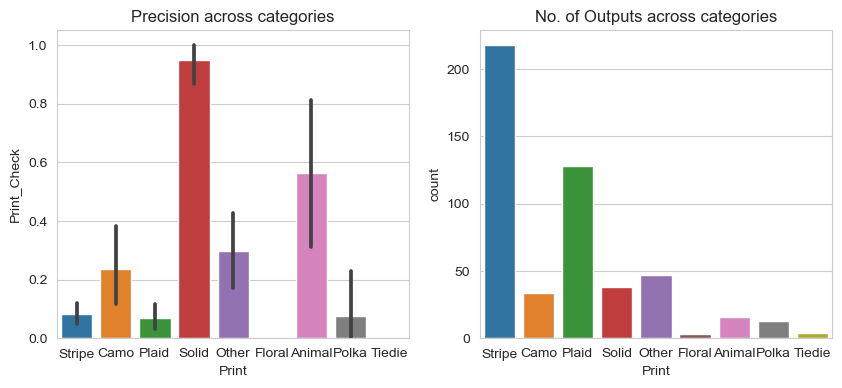

In [3]:
# Visualize the output without data augmentation
sns.set_style("whitegrid")

plt.figure(figsize=(10,4))

plt.subplot(121)
g1 = sns.barplot(y='Print_Check', x='Print', data=df_ck)
g1.set_title("Precision across categories")

plt.subplot(122)
g2 = sns.countplot(x='Print', data=df_ck)
g2.set_title("No. of Outputs across categories")

plt.show()

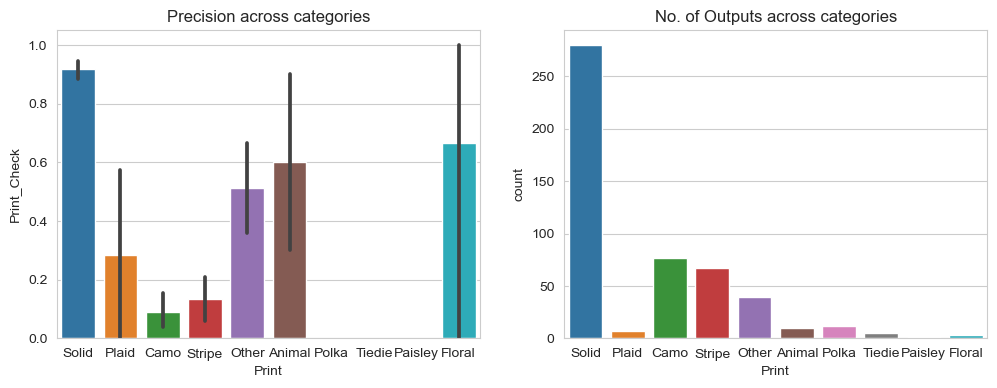

In [4]:
# Visualize the output with data augmentation
sns.set_style("whitegrid")

plt.figure(figsize=(12,4))

plt.subplot(121)
g1 = sns.barplot(y='Print_Check', x='Print', data=df_ck_aug)
g1.set_title("Precision across categories")

plt.subplot(122)
g2 = sns.countplot(x='Print', data=df_ck_aug)
g2.set_title("No. of Outputs across categories")

plt.show()

There are a lot more "Solid" print in the sample dataset and quite few for other categories. Therefore, the precisions for other categories are not reliable. Further explorations/validations are needed.

### 6) Determine the direction of the next step - Apply the model to the full dataset

In [4]:
# Check readability of images, exclude unreadable images
full_pics = os.listdir('pics')

for i in full_pics:
    try:
        image = load(f'pics/{i}')
    except:
        os.remove(f'pics/{i}')
        
print(len(os.listdir('pics')), "images are readable and now in the pics file.")

4637 images are readable and now in the pics file.


In [27]:
# Predict labels on the full data set and write labels into a csv file
with open('outputs_full.csv', 'w', newline='') as file:
    csvwriter = csv.writer(file)
    csvwriter.writerow(['Image', 'Print', 'Print Prob'])
    for i in os.listdir("pics"):
        image = load(f'pics/{i}')
        print_outcome = print_model.predict(image)
        print_label = print_labels[np.argmax(print_outcome)]
        print_prob = np.max(print_outcome)
        csvwriter.writerow([i, print_label, print_prob])

1/1 [==============================] - 0s 208ms/step


1/1 [==============================] - 0s 217ms/step


1/1 [==============================] - 0s 206ms/step


1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 219ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 240ms/step


1/1 [==============================] - 0s 329ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 368ms/step


1/1 [==============================] - 0s 474ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 448ms/step


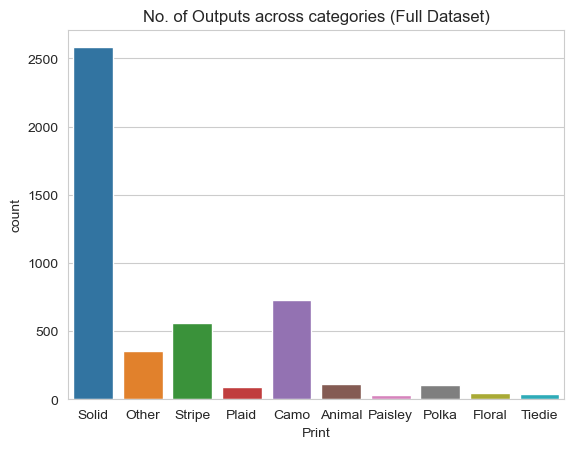

In [55]:
# Visualize the distribution of predicted categories
df_full = pd.read_csv("outputs_full.csv")

sns.countplot(x='Print', data=df_full)
plt.title("No. of Outputs across categories (Full Dataset)")
plt.show()

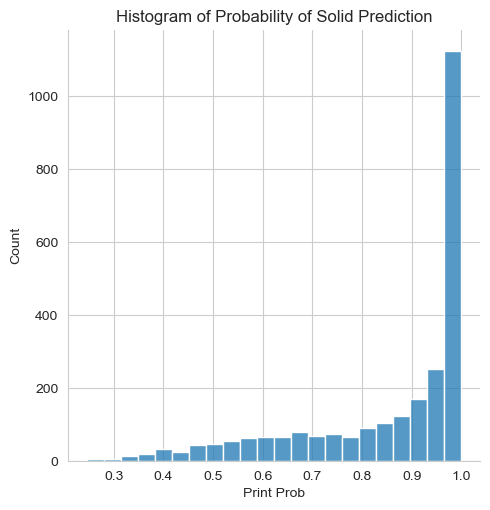

In [53]:
# Check the distribution of the prediction probobility for the Solid print
sns.displot(x='Print Prob', data=df_full[df_full['Print']=="Solid"], kind='hist')
plt.title("Histogram of Probability of Solid Prediction")
plt.show()

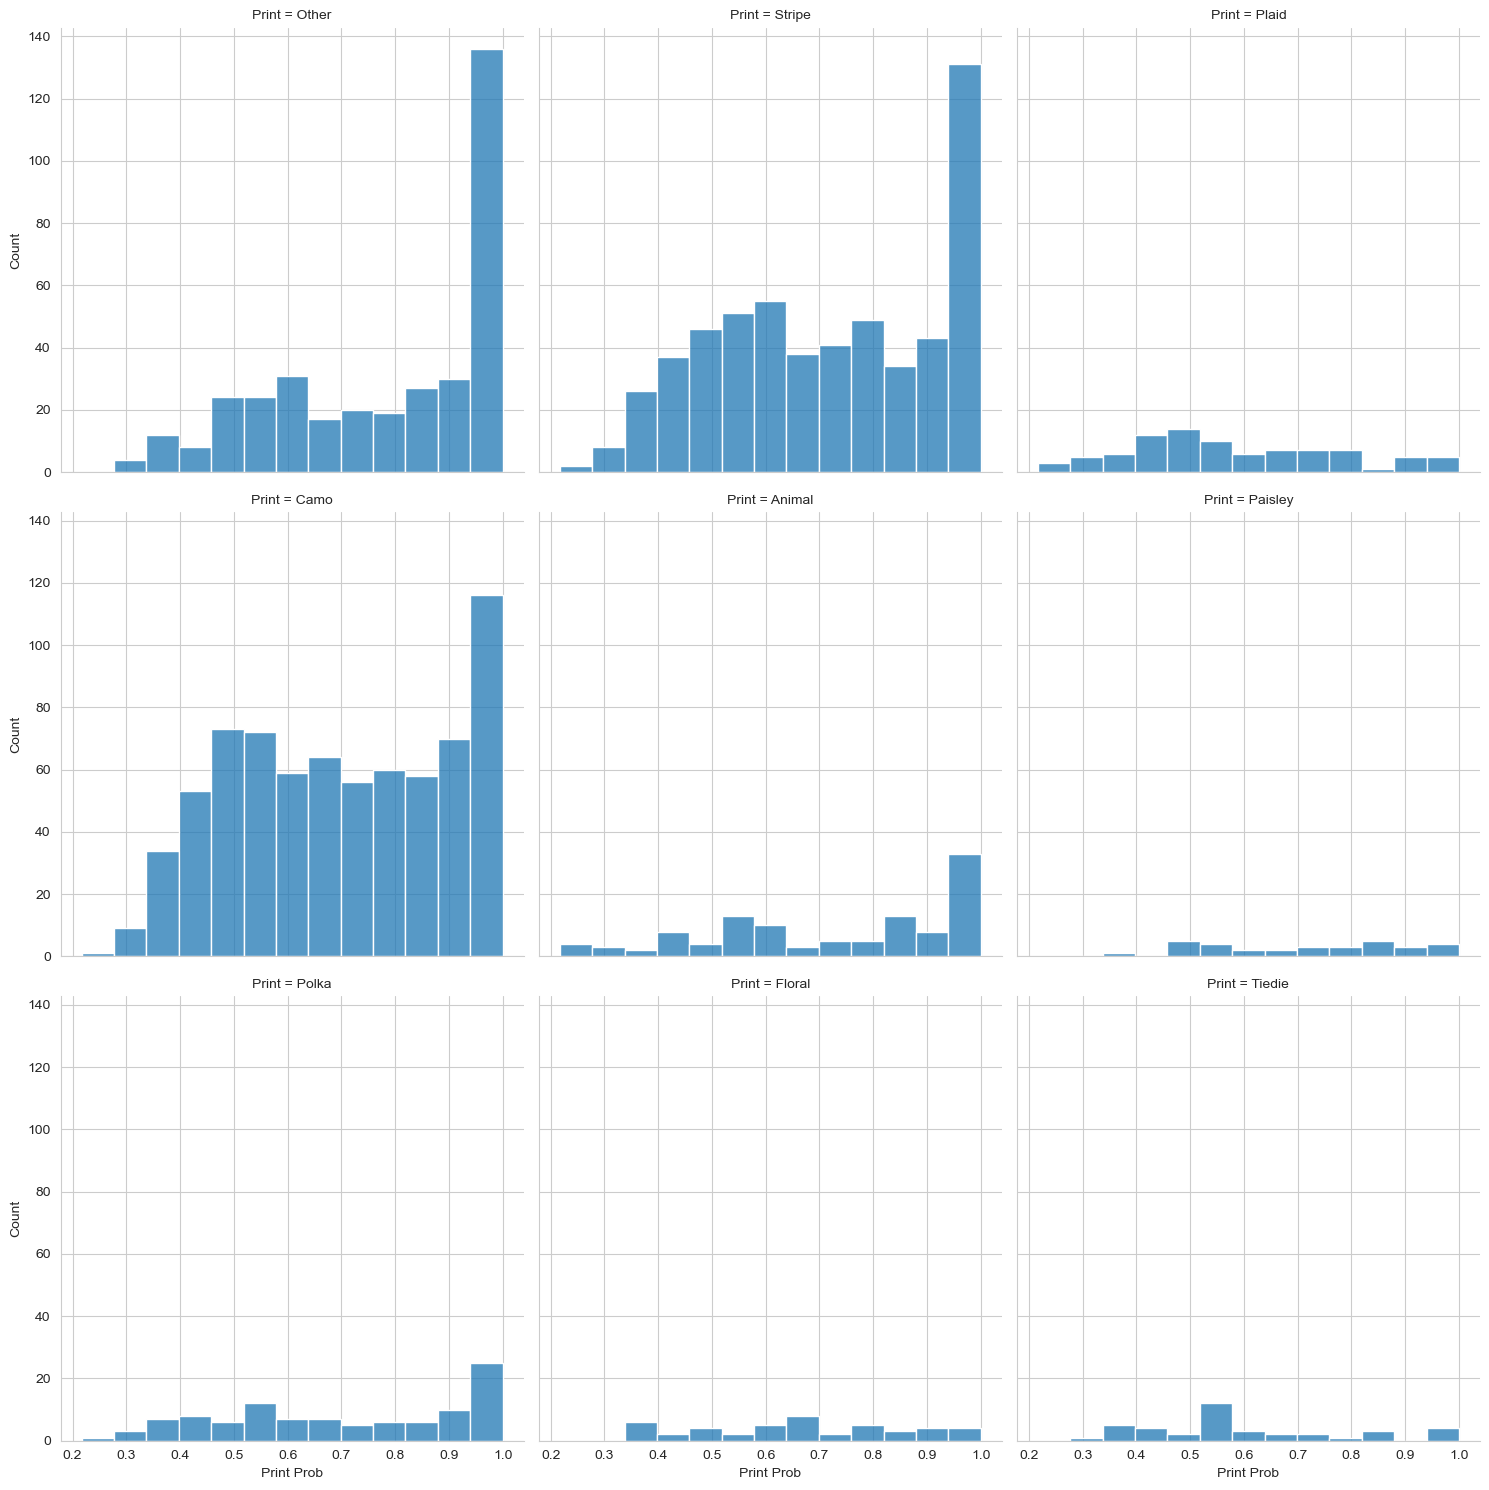

In [54]:
# Check the distributions of prediction probability for other categories
sns.displot(x='Print Prob', data=df_full[df_full['Print']!="Solid"], kind='hist', col='Print', col_wrap=3)
plt.show()

There seem to be more images that are predicted to be belonged to "Other", "Stripe", and "Camo" print categories. Further studies can focus on how the model actually performs on the three categories. "Animal" and "Polka" also have a relatively significant surge when the probabilities get close to 1. These two categories can be regarded as secondary priorities.